In [ ]:
# Imports
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import joblib


In [ ]:
# 1) Load raw CSV (assumes the file is in ../1_raw/IMDB-raw.csv or working dir)
# If you saved a cleaned CSV earlier in ../3_data/clean_imdb_dataset.csv you may load that instead.
df = pd.read_csv("IMDB-Dataset.csv")   # or "../1_raw/IMDB-raw.csv"

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (50000, 2)
Columns: ['review', 'sentiment']


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Basic inspection
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())
print("\nSentiment distribution:\n", df['sentiment'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Missing values per column:
 review       0
sentiment    0
dtype: int64

Duplicate rows: 418

Sentiment distribution:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [ ]:
# 2) Drop duplicates and create numeric label
df = df.drop_duplicates().reset_index(drop=True)
df['label'] = df['sentiment'].map({'positive':1, 'negative':0})

# 3) Clean text (same function as Notebook_A)
def clean_review(text):
    # remove HTML tags
    text = BeautifulSoup(str(text), "html.parser").get_text(separator=" ")
    text = text.lower()
    # remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)
    # remove non-alphanumeric characters
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_review'] = df['review'].apply(clean_review)

# Show sample
df[['review','clean_review','sentiment','label']].head(3)


,review,clean_review,sentiment,label
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...,positive,1
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,positive,1


In [ ]:
# 4) Create X and y, and split (same random_state for reproducibility)
X = df['clean_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 39665 Test size: 9917


In [ ]:
# 5) TF-IDF (use same config as Model 1)
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    stop_words='english',
    sublinear_tf=True
)

# Fit TF-IDF on training data and transform both
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (39665, 50000) (9917, 50000)


In [ ]:
# 6) Train LinearSVC
svm_model = LinearSVC(max_iter=5000)   # increase iter if needed
svm_model.fit(X_train_tfidf, y_train)


LinearSVC(max_iter=5000)

Accuracy: 0.8999697489160028
ROC AUC: 0.9643095079470829

Classification Report:
               precision    recall  f1-score   support

           0     0.9043    0.8937    0.8990      4940
           1     0.8957    0.9062    0.9009      4977

    accuracy                         0.9000      9917
   macro avg     0.9000    0.8999    0.9000      9917
weighted avg     0.9000    0.9000    0.9000      9917



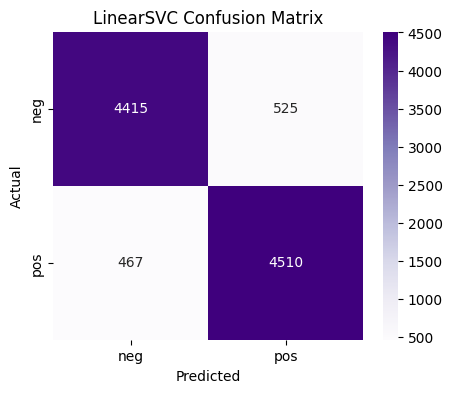

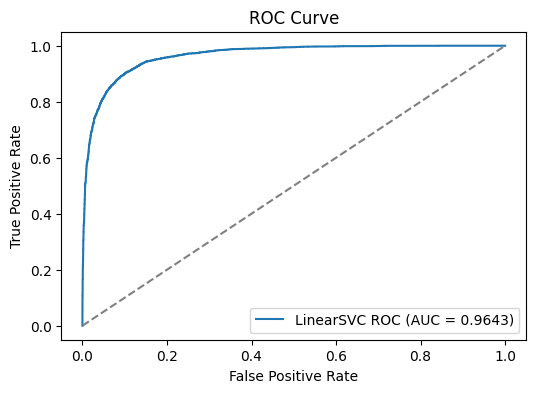

In [ ]:
# 7) Predictions & metrics
y_pred = svm_model.predict(X_test_tfidf)

# For ROC AUC we use decision_function with LinearSVC
y_scores = svm_model.decision_function(X_test_tfidf)
roc_auc = roc_auc_score(y_test, y_scores)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['neg','pos'], yticklabels=['neg','pos'])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("LinearSVC Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'LinearSVC ROC (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.show()


In [ ]:
# 8) Save the TF-IDF + model as a pipeline for reuse
pipe_svm = Pipeline([
    ('tfidf', tfidf),
    ('clf', svm_model)
])

joblib.dump(pipe_svm, "tfidf_linearsvc_pipeline.joblib")   # or "../4_models/tfidf_linearsvc_pipeline.joblib"
print("Saved pipeline to tfidf_linearsvc_pipeline.joblib")


Saved pipeline to tfidf_linearsvc_pipeline.joblib
